Check effect of Negative Voja learning rule on MEG response

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

import nengo
from nengo.utils.matplotlib import rasterplot
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import make_alt_vocab, BasicVecFeed, meg_from_spikes
from nengo_learn_assoc_mem.learning_rules.neg_voja import NegVoja
from nengo_learn_assoc_mem.learning_rules import rec_bcm

from collections import namedtuple

# 2D

## Setup

In [ ]:
n_neurons = 100
n_items = 16
dimensions = 2
seed = 8

intercepts = [0.8]*n_neurons

In [ ]:
vocab, fan1, fan1_pair_vecs, fan2, fan2_pair_vecs, foil1, foil1_pair_vecs, foil2, foil2_pair_vecs = make_alt_vocab(n_items, n_items, dimensions, seed, norm=True)

In [ ]:
fan1_pairs = np.array(fan1_pair_vecs)
fan2_pairs = np.array(fan2_pair_vecs)
fan1_mean = np.mean(fan1_pair_vecs, axis=0)
fan2_mean = np.mean(fan2_pair_vecs, axis=0)

In [ ]:
x_val = np.linspace(0, 2*np.pi, n_neurons)
enc = np.array([np.cos(x_val), np.sin(x_val)]).T

plt.scatter(fan1_pairs[:, 0], fan1_pairs[:, 1], label="fan1", color='r')
plt.scatter(fan1_mean[0], fan1_mean[1], color='r')
plt.scatter(fan2_pairs[:, 0], fan2_pairs[:, 1], label="fan2", color='b')
plt.scatter(fan2_mean[0], fan2_mean[1], color='b')
plt.scatter(enc[:, 0], enc[:, 1], color='k', alpha=0.3)

plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)

## Simulation

In [ ]:
with nengo.Network() as model:
    ens = nengo.Ensemble(n_neurons, dimensions, intercepts=intercepts, seed=seed)

with nengo.Simulator(model) as sim:
    pass

enc = sim.data[ens].encoders.copy()

In [ ]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs

n_repeats = 5
t_pause = 0.1
t_present = 0.3
t_each = t_pause + t_present

td_pause = t_pause/dt

dt = 0.001

In [ ]:
feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengo.Network() as model:
    in_nd = nengo.Node(feed.feed)
    paused = nengo.Node(lambda t: 1-feed.paused)

    neg_voja = NegVoja(enc.copy(), learning_rate=(5e-6 / n_repeats))
    ens = nengo.Ensemble(n_neurons, dimensions, intercepts=intercepts, seed=seed)

    nengo.Connection(in_nd, neg_voja.input_signal, synapse=None)
    nengo.Connection(ens.neurons, neg_voja.input_activities, synapse=0)
    nengo.Connection(paused, neg_voja.enable, synapse=None)
    nengo.Connection(neg_voja.output, ens.neurons, synapse=None)

    p_in = nengo.Probe(in_nd)
    p_spikes = nengo.Probe(ens.neurons)

with nengo.Simulator(model) as sim:
    sim.run(n_repeats*len(feed_vecs)*t_each + t_pause)

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
ax1.plot(sim.trange(), sim.data[p_in])
rasterplot(sim.trange(), sim.data[p_spikes], ax=ax2)

In [ ]:
fin_enc = neg_voja.encoder_hist[-1]

In [ ]:
#plt.scatter(enc[:, 0], enc[:, 1])
plt.scatter(fin_enc[:, 0], fin_enc[:, 1], alpha=0.4)
plt.scatter(fan1_pairs[:, 0], fan1_pairs[:, 1], label="fan1", color='r')
plt.scatter(fan2_pairs[:, 0], fan2_pairs[:, 1], label="fan2", color='b')

## Verification

In [ ]:
with nengo.Network() as model:
    ens = nengo.Ensemble(n_neurons, dimensions, encoders=fin_enc, intercepts=intercepts, seed=seed)
sim = nengo.Simulator(model)

In [ ]:
Stim = namedtuple("Stim", ['fan_num', 'targ', 'vecs'])

In [ ]:
stim_vecs = {"fan1": Stim(1, True, np.array(fan1_pair_vecs)),
             "fan2": Stim(2, True, np.array(fan2_pair_vecs))}

In [ ]:
df_list = []

for key, obj in stim_vecs.items():
    _, act = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=obj.vecs)

    flat_act = list(act.flatten())
    resp = [obj.fan_num] * len(flat_act)
    targ = [obj.targ] * len(flat_act)
    df_list.append(pd.DataFrame({"act": flat_act, "resp": resp, "targ": targ}))

act_df = pd.concat(df_list)

In [ ]:
ax = sns.barplot(x="resp", y="act", data=act_df)

ax.set_title("Difference between FAN1 and FAN2 firing rates")
ax.set_ylabel("Mean Firing Rate")
ax.set_xlabel("FAN type");

# Full Vocab

In [2]:
n_items = 16
dimensions = 32
n_neurons = 500

dt = 0.001
seed = 8

vocab, fan1, fan1_pair_vecs, fan2, fan2_pair_vecs, foil1, foil1_pair_vecs, foil2, foil2_pair_vecs = make_alt_vocab(n_items, n_items, dimensions, seed, norm=True)

In [3]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs

n_repeats = 5
t_pause = 0.1
t_present = 0.3
t_each = t_pause + t_present

td_pause = t_pause/dt

intercepts = [0.2]*n_neurons

In [4]:
with nengo.Network() as model:
    ens = nengo.Ensemble(n_neurons, dimensions, intercepts=intercepts, seed=seed)

with nengo.Simulator(model) as sim:
    pass

enc = sim.data[ens].encoders.copy()

Building finished in 0:00:01.                                                   


In [5]:
feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengo.Network() as model:
    in_nd = nengo.Node(feed.feed)
    paused = nengo.Node(lambda t: 1-feed.paused)

    neg_voja = NegVoja(enc.copy(), learning_rate=(5e-6 / n_repeats))
    ens = nengo.Ensemble(n_neurons, dimensions, intercepts=intercepts, seed=seed)

    nengo.Connection(in_nd, neg_voja.input_signal, synapse=None)
    nengo.Connection(ens.neurons, neg_voja.input_activities, synapse=0)
    nengo.Connection(paused, neg_voja.enable, synapse=None)
    nengo.Connection(neg_voja.output, ens.neurons, synapse=None)

    p_in = nengo.Probe(in_nd)
    p_spikes = nengo.Probe(ens.neurons)

with nengo.Simulator(model) as sim:
    sim.run(n_repeats*len(feed_vecs)*t_each + t_pause)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:49.                                                 


In [6]:
fin_enc = neg_voja.encoder_hist[-1].copy()

## Verification

In [7]:
with nengo.Network() as model:
    ens = nengo.Ensemble(n_neurons, dimensions, encoders=fin_enc, intercepts=intercepts, seed=seed)
sim = nengo.Simulator(model)

Building finished in 0:00:01.                                                   


In [8]:
Stim = namedtuple("Stim", ['fan_num', 'targ', 'vecs'])

In [9]:
stim_vecs = {"fan1": Stim(1, True, np.array(fan1_pair_vecs)),
             "fan2": Stim(2, True, np.array(fan2_pair_vecs)),
             "foil1": Stim(1, False, np.array(foil1_pair_vecs)),
             "foil2": Stim(2, False, np.array(foil2_pair_vecs))}

In [10]:
df_list = []

for key, obj in stim_vecs.items():
    _, act = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=obj.vecs)

    flat_act = list(act.flatten())
    resp = [obj.fan_num] * len(flat_act)
    targ = [obj.targ] * len(flat_act)
    df_list.append(pd.DataFrame({"act": flat_act, "resp": resp, "targ": targ}))

act_df = pd.concat(df_list)

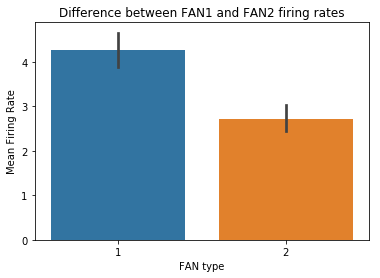

In [11]:
ax = sns.barplot(x="resp", y="act", data=act_df[act_df.targ == True])

ax.set_title("Difference between FAN1 and FAN2 firing rates")
ax.set_ylabel("Mean Firing Rate")
ax.set_xlabel("FAN type");

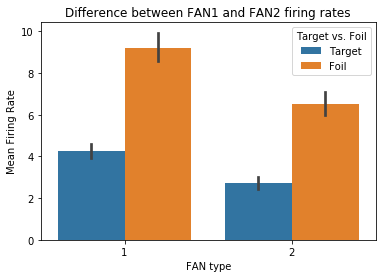

In [12]:
ax = sns.barplot(x="resp", y="act", hue="targ", hue_order=(True, False), data=act_df)

ax.set_title("Difference between FAN1 and FAN2 firing rates")
ax.set_ylabel("Mean Firing Rate")
ax.set_xlabel("FAN type")

ax.legend_.set_title("Target vs. Foil")
new_labels = ("Target", "Foil")
for t, l in zip(ax.legend_.texts, new_labels): t.set_text(l)

## Add recurrent inhibition

In the hopes it might exaggerate existing trends

In [ ]:
t_pause = 0.4
t_present = 0.3
t_each = t_pause + t_present

td_pause = int(t_pause / dt)
td_each = int(t_each / dt)

In [ ]:
rec_inhib = (-1*np.ones(n_neurons) + np.eye(n_neurons)) / 1e5

feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengo.Network() as model:
    in_nd = nengo.Node(feed.feed)
    paused = nengo.Node(lambda t: 1-feed.paused)

    neg_voja = NegVoja(enc.copy(), learning_rate=(5e-6 / n_repeats))
    ens = nengo.Ensemble(n_neurons, dimensions, intercepts=intercepts, seed=seed)

    nengo.Connection(in_nd, neg_voja.input_signal, synapse=None)
    nengo.Connection(ens.neurons, neg_voja.input_activities, synapse=0)
    nengo.Connection(paused, neg_voja.enable, synapse=None)
    nengo.Connection(neg_voja.output, ens.neurons, synapse=None)
    
    nengo.Connection(ens.neurons, ens.neurons, transform=rec_inhib)

    p_in = nengo.Probe(in_nd)
    p_spikes = nengo.Probe(ens.neurons)

with nengo.Simulator(model) as sim:
    sim.run(len(feed_vecs)*t_each + t_pause)

In [ ]:
meg_sig = meg_from_spikes(sim.data[p_spikes])

In [ ]:
len(fan1)

In [ ]:
fan1_slc = slice(td_pause, td_each*len(fan1)+td_pause)
fan2_slc = slice(fan1_slc.stop, td_each*len(feed_vecs)+td_pause)

In [ ]:
plt.figure(figsize=(12, 3))
plt.plot(sim.trange()[fan1_slc], meg_sig[fan1_slc])
plt.plot(sim.trange()[fan2_slc], meg_sig[fan2_slc])

In [ ]:
columns = ("vec", "resp")

a1 = meg_sig[fan1_slc].flatten()
l1 = ["fan1"] * len(a1)
s1 = [True] * len(a1)
p1 = pd.DataFrame({"vec": l1, "resp": list(a1), "inhib": s1})


a2 = meg_sig[fan2_slc].flatten()
l2 = ["fan2"] * len(a2)
s2 = [True] * len(a2)
p2 = pd.DataFrame({"vec": l2, "resp": list(a2), "inhib": s2})

acts = pd.concat((p1, p2))

In [ ]:
ax = sns.barplot(x="vec", y="resp", data=acts)
ax.set_ylim((2000, 2500))